In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
from scipy import interpolate,stats
from scipy.integrate import quad
import scipy.optimize as op
import sys, os
import hmf

In [2]:
###### constants ######
Mpc=3.086e+24#cm
c = 299792.458#km/s
Gnewton = 6.674e-8#cgs cm^3/g/s^2
H0 = 70.0#67.74
h = H0/100.0
OmegaM = 0.30#1#Planck15 TT,TE,EE+lowP+lensing+ext
OmegaV = 1.0-OmegaM
#rho_c0 = 9.9e-30#g/cm^3
M_sun = 1.989e33#gram
# growth factor
Hcgs = lambda z: H0*sqrt(OmegaM*(1+z)**3+OmegaV)*3.24e-20
H_inv = lambda z: 1.0/(H0*sqrt(OmegaM*(1+z)**3+OmegaV))
# luminosity distance Mpc
DC_integral = lambda z: c*quad(H_inv, 0, z)[0]
z_arr = linspace(0.0, 2.0, 201)
DC_arr0 = array([DC_integral(z) for z in z_arr])
DC = interpolate.interp1d(z_arr, DC_arr0)
DA = lambda z: DC(z)/(1.0+z)
DL = lambda z: DC(z)*(1.0+z)
##rho_cz = lambda z: rho_c0*(OmegaM*(1+z)**3+(1-OmegaM))
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton#critical density
dd = lambda z: OmegaM*(1+z)**3/(OmegaM*(1+z)**3+OmegaV)
Delta_vir = lambda z: 18.0*pi**2+82.0*dd(z)-39.0*dd(z)**2
Rvir_fcn = lambda Mvir, z: (0.75/pi * Mvir*M_sun/(Delta_vir(z)*rho_cz(z)))**0.3333

In [3]:
###### source galaxies ######
z0 = 0.4 ## mean redshift 
ngal_mean = 20 ## number density in unit of arcmin^-2
zlo, zhi= 0, 2.0 ## the redshift cuts
Pz = lambda z: 0.5*z**2/z0**3*exp(-z/z0) ## P(z)
z_choices = linspace(zlo,zhi,101) ## center of z bins
prob = Pz(z_choices)
prob /= sum(prob)
## redshift and Ngal generator
redshift_gen = lambda N: np.random.choice(z_choices, size=N, p=prob)
Ngal_gen = lambda N: np.random.poisson(N)

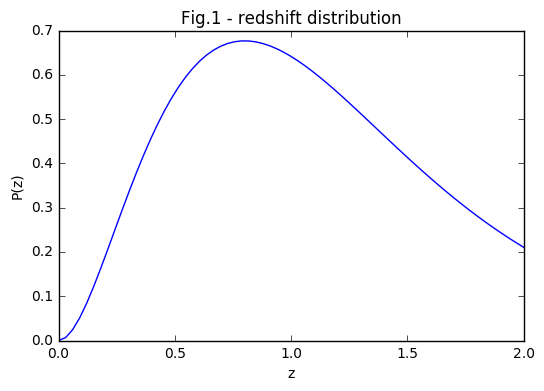

In [56]:
z_arr = linspace(0,3,100)
plot(z_arr,Pz(z_arr))
xlabel('z');ylabel('P(z)')
xlim(0,2)
title('Fig.1 - redshift distribution')
show()

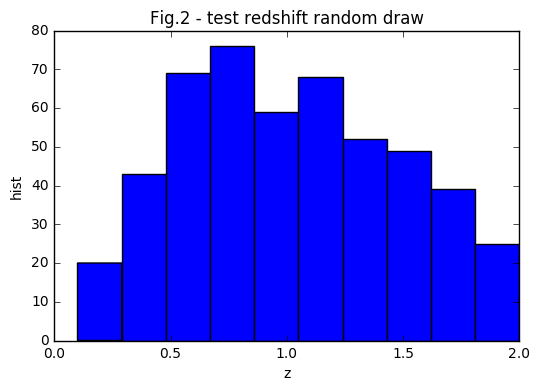

In [57]:
sample = redshift_gen(500)
hist(sample);xlabel('z');ylabel('hist');
title('Fig.2 - test redshift random draw')
show()

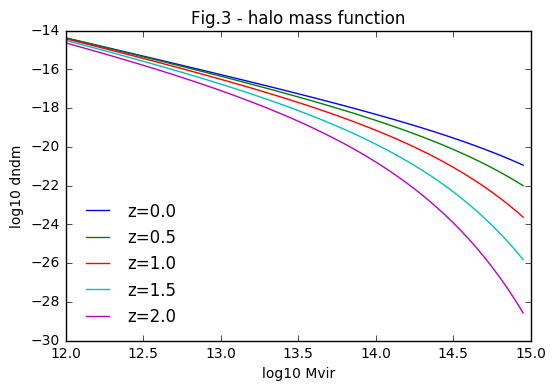

In [93]:
###### halo mass function ######
Mmin, Mmax, dlog10m=12, 15, 0.05
dndm_arr = array([hmf.MassFunction(z=iz, Mmin=Mmin, Mmax=Mmax, dlog10m=dlog10m).dndm for iz in z_choices])
# save('dndm_arr.npy',dndm_arr)
z_arr, M_arr = z_choices, arange(Mmin,Mmax,dlog10m)

for iii in range(5):
    plot(M_arr, log10(dndm_arr[25*iii]),label='z=%s'%(z_choices[25*iii]))
xlabel('log10 Mvir')
ylabel('log10 dndm')
title('Fig.3 - halo mass function')
legend(frameon=0,loc=0)
show()


In [ ]:
#dndm_arr = load('dndm_arr.npy')
dndm_arr /= sum(dndm_arr,axis=1).reshape(-1,1)



z_lens = redshift_gen(1) ## lens redshift
M_lens = np.random.choice(M_arr, p=dndm_arr[z_arr==z_lens][0]) ## find lens mass
### HOD
A, B, C = 47.0, 0.85, -0.1
N_lens_fcn = lambda logM, z: A*(10**(logM-14.0)/h)**B*(1+z)**C - 1.0
N_lens = int(N_lens_fcn(M_lens, z_lens) + 0.5)
print M_lens, z_lens, N_lens
Cvir = lambda logM, z: 10**(0.537+0.488*exp(-0.718*z**1.08)+(-0.097+0.024*z)* (logM-12-log10(2.0/h))  )

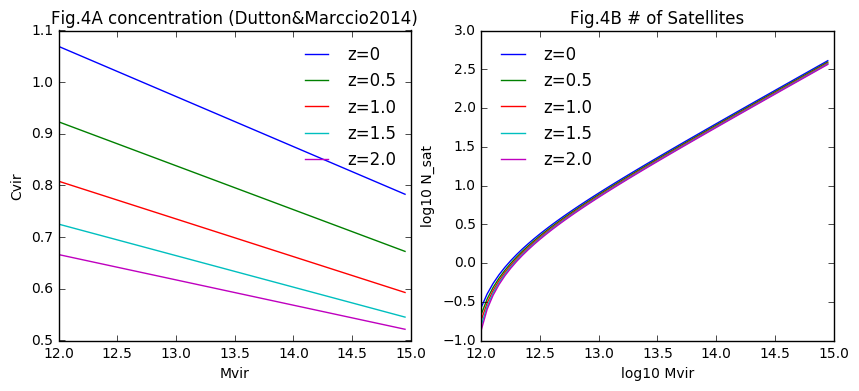

In [94]:
figure(figsize=(10,4))
subplot(121)
[plot(M_arr, log10(Cvir(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('Mvir')
ylabel('Cvir')
legend(frameon=0,loc=0)
title('Fig.4A concentration (Dutton&Marccio2014)')
subplot(122)
[plot(M_arr, log10(N_lens_fcn(M_arr, iz)), label='z=%s'%(iz)) for iz in (0,0.5,1.0,1.5,2.0)]
xlabel('log10 Mvir')
ylabel('log10 N_sat')
title('Fig.4B # of Satellites')
legend(frameon=0,loc=0)
show()

In [13]:
def Gx_fcn (x, cNFW):#=5.0):
    '''projection function for a halo with cNFW, at location x=theta/theta_s.
    '''
    if x < 1:
        out = 1.0/(x**2-1.0)*sqrt(cNFW**2-x**2)/(cNFW+1.0)+1.0/(1.0-x**2)**1.5*arccosh((x**2+cNFW)/x/(cNFW+1.0))
    elif x == 1:
        out = sqrt(cNFW**2-1.0)/(cNFW+1.0)**2*(cNFW+2.0)/3.0
    elif 1 < x <= cNFW:
        out = 1.0/(x**2-1.0)*sqrt(cNFW**2-x**2)/(cNFW+1.0)-1.0/(x**2-1.0)**1.5*arccos((x**2+cNFW)/x/(cNFW+1.0))
    elif x > cNFW:
        out = 0
    return out

In [86]:
def kappa_proj (logM,  z_lens, z_source_arr, x_source_arr, y_source_arr, x_lens=0, y_lens=0):
    '''return a function, for certain foreground halo, 
    calculate the projected mass between a foreground halo and a background galaxy pair. 
    x, y are in arcmin.
    ''' 

    Mvir = 10**logM
    Rvir = Rvir_fcn(Mvir,z_lens)
    DC_lens, DC_source = DC(z_lens), DC(z_source_arr)
    cNFW = Cvir(logM, z)
    f = 1.0/(log(1.0+cNFW)-cNFW/(1.0+cNFW))# = 1.043 with cNFW=5.0
    two_rhos_rs = Mvir*M_sun*f*cNFW**2/(2*pi*Rvir**2)#cgs, see LK2014 footnote
    
    Dl_cm = 3.08567758e24*DC_lens/(1.0+z_lens)
    ## note: 3.08567758e24cm = 1Mpc###    
    SIGMAc = 347.29163*DC_source*(1+z_lens)/(DC_lens*(DC_source-DC_lens))
    ## note: SIGMAc = 1.07163e+27/DlDlsDs
    ## (c*1e5)**2/4.0/pi/Gnewton = 1.0716311756473212e+27
    ## 347.2916311625792 = 1.07163e+27/3.08567758e24
    theta_arcmin = sqrt((x_lens-x_source_arr)**2+(y_lens-y_source_arr)**2)
    theta = radians(theta_arcmin/60.0)
    x = cNFW*theta*Dl_cm/Rvir 
    ## note: x=theta/theta_s, theta_s = theta_vir/c_NFW
    ## theta_vir=Rvir/Dl_cm
    Gx_arr = array([Gx_fcn(ix, cNFW) for ix in x])
    kappa_p = two_rhos_rs/SIGMAc*Gx_arr  
    kappa_p[z_source_arr<z_lens]=0
    source_contribution = exp(-0.5*theta**2/radians(1.0/60.0)**2)
    kappa = sum(kappa_p * source_contribution)/sum(source_contribution)
    return kappa

In [31]:
########## test run with one massive lens ############
M_lens = 14.5
z_lens = 0.4
N_lens = int(N_lens_fcn(M_lens, z_lens) + 0.5)

seed(0)
Mvir = 10**M_lens
cNFW = Cvir(M_lens, z_lens)
Rvir = Rvir_fcn(Mvir,z_lens)
ngal_like_fcn = lambda cNFW: array([Gx_fcn(ix, cNFW) for ix in linspace(0.01, cNFW, 51)]).T
ngal_like = ngal_like_fcn(cNFW)/sum(ngal_like_fcn(cNFW))
rlenses = Rvir/Mpc/DC(z_lens) * np.random.choice(linspace(0.01, 1.0, 51), size=N_lens, p=ngal_like)#radians
ang_lenses = rand(N_lens)*2*pi
xlens = degrees(rlenses)*60.0 * sin(ang_lenses) ## in arcmin
ylens = degrees(rlenses)*60.0 * cos(ang_lenses) ## in arcmin

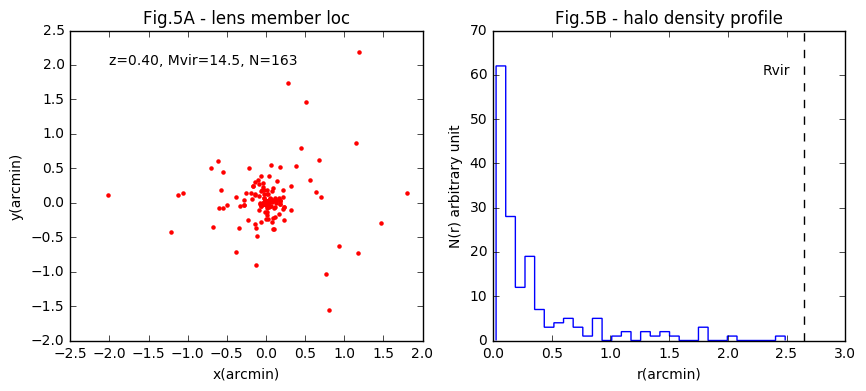

In [84]:
figure(figsize=(10,4))
subplot(121)
scatter(xlens, ylens, c='r', s=5, edgecolor='r')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.5A - lens member loc')
text(-2,2,'z=%.2f, Mvir=%.1f, N=%i'%(z_lens, M_lens, N_lens))
subplot(122)
theta_vir = degrees(Rvir/Mpc/DC(z_lens))*60.0
hist(degrees(rlenses)*60.0, bins=30,histtype='step')
plot([theta_vir,theta_vir],[0,70],'k--')
xlabel('r(arcmin)')
ylabel('N(r) arbitrary unit')
text(2.3,60,'Rvir')
title('Fig.5B - halo density profile')
show()

In [ ]:
side = 10.0
area = side**2 ## arcmin^2
N_gal = Ngal_gen(ngal_mean * area)
z_source_arr = redshift_gen(N_gal)
x_source_arr = rand(N_gal) * side
y_source_arr = rand(N_gal) * side


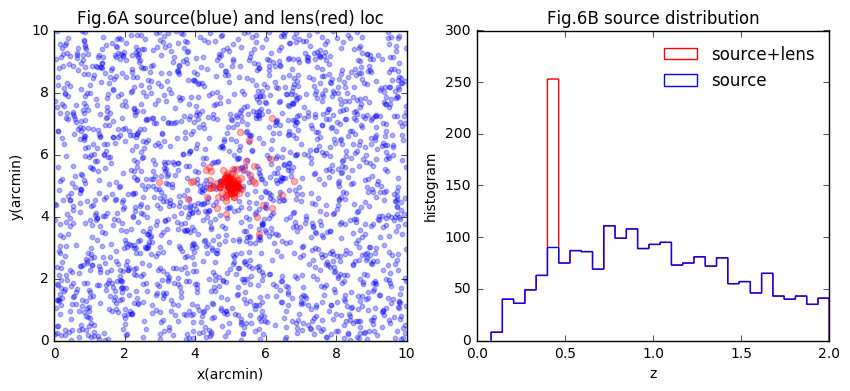

In [104]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens+side/2, ylens+side/2, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.6A - source(blue) and lens(red) loc')
xlim(0,side)
ylim(0,side)
subplot(122)
hist(concatenate([z_source_arr, ones(N_lens)*z_lens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.6B - source distribution')
show()

In [90]:
kappa_real = kappa_proj (M_lens,  z_lens, z_source_arr, x_source_arr, y_source_arr, x_lens=0, y_lens=0)
print kappa_real

0.0661794022091


/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


In [106]:
########################################
######## add magnification bias ########
########################################
beta = 0.6
sslope = 0.32 + beta
N_source_back = sum( (z_source_arr>z_lens) & ( sqrt((x_source_arr-side/2)**2 + (y_source_arr-side/2)**2) <theta_vir))
N_source_new = N_source_back * (5.0*sslope-2.0) * kappa_real
N_source_new = int(N_source_new+0.5)
## new position and redshift, but limit to higher redshift
z_source_new = np.random.choice(z_choices[z_choices>z_lens], size=N_source_new, 
                                p=prob[z_choices>z_lens]/sum (prob[z_choices>z_lens]))
ang_new = rand(N_source_new)*2*pi
x_source_new = theta_vir * rand(N_source_new) * sin(ang_new)
y_source_new = theta_vir * rand(N_source_new) * cos(ang_new)
#print N_source_back, N_source_new #sum(z_source_arr>z_lens), (5.0*sslope-2.0), kappa_real

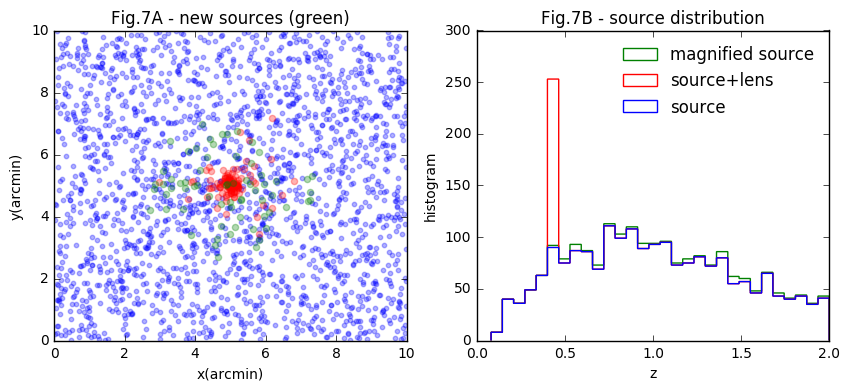

In [108]:
figure(figsize=(10,4))
subplot(121)
scatter(x_source_arr, y_source_arr, s=10, edgecolor='b',c='b',alpha=0.3)#,facecolors='none')
scatter(xlens+side/2, ylens+side/2, s=20, edgecolor='r',c='r',alpha=0.3)#,facecolors='none')
scatter(x_source_new+side/2, y_source_new+side/2, s=20, edgecolor='g',c='g',alpha=0.3)#,facecolors='none')
xlabel('x(arcmin)')
ylabel('y(arcmin)')
title('Fig.7A - new sources (green)')
xlim(0,side)
ylim(0,side)
subplot(122)
hist(concatenate([z_source_arr, z_source_new]), bins=30, color='g',histtype='step', label='magnified source')
hist(concatenate([z_source_arr, ones(N_lens)*z_lens]), bins=30, color='r',histtype='step', label='source+lens')
hist(z_source_arr, bins=30, histtype='step',color='b', label='source')
legend(frameon=0,loc=0)
xlabel('z')
ylabel('histogram')
title('Fig.7B - source distribution')
show()